# Building Multi-label Classifiers
## Neural Network using Keras deep learning API on top of TensorFlow

#### In this notebook, the authors build a neural network classifier for multilabel classification. The order of the notebook is as follows:
- Building a Neural Network Classifier 
- Fine-tuning the Neural Network Classifier using Grid Search
- Over sampling using SMOTE 
- Repeat procedures 1 and 2

In [138]:
#Generic library imports and data import
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import pandas as pd
import csv
import ast
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

data = pd.read_csv('../Data_sets/Master_cleaned.csv')

#Functions

def remove_unwanted_observations(data, unwanted_observations = ["['Oily', 'Sensitive']",
                                                                "['Dry', 'Normal', 'Oily']",
                                                                "['Dry', 'Oily']",
                                                                "['Dry', 'Normal', 'Oily', 'Sensitive']",
                                                                "['Combination', 'Dry', 'Oily', 'Sensitive']",
                                                                "['Normal', 'Oily']"
                                                                ]):
    for observation in unwanted_observations:
        data = data[data.Skin_Type != observation]
    
    return data

In [139]:
# Specific Libary imports and functions

from keras.models import Sequential 
from keras.layers import Dense, Dropout
from keras.regularizers import l2
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
import keras as Keras

# set seed for reproductibility 
np.random.seed(1024)

## 1. Post Processing Data

In [169]:
#Split Data
data = remove_unwanted_observations(data)
X = data[data.columns[17:28]].values
y = data.Skin_Type

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, random_state = np.random, stratify=y)

def create_network(X_train=X_train, y_train=y_train):
    print(f"made it to the function! heres x_train:\n{X_train}\nand here's y_train:\n{y_train}")
    # create model 
    network = Sequential()
    #hidden layer
    network.add(Dense(20, input_dim=X_train.shape[1], kernel_initializer ="random_uniform", activation = 'relu'))
    #network.add(Dense(20, activation = 'relu', kernel_regularizer = l2(.01)))
    #output layer
    network.add(Dense(y_train.shape[1], activation ='sigmoid'))
    # compile model 
    network.compile(loss="binary_crossentropy", 
                    optimizer = 'adam', 
                    metrics =['accuracy'])
    return network



In [170]:
y_train = y_train.apply(ast.literal_eval)
y_test = y_test.apply(ast.literal_eval)

mlb=MultiLabelBinarizer()
y_train = mlb.fit_transform(y_train)
y_test = mlb.transform(y_test)
mlb.classes_

array(['Combination', 'Dry', 'Normal', 'Oily', 'Sensitive'], dtype=object)

In [171]:
# defining the baseline model:
def build_network(initializer, act, units,dropout_rate = 0.2):
    classifier = Sequential()
    #First Hidden Layer
    classifier.add(Dense(units=units, activation=act , kernel_initializer= initializer, input_dim=11))
    classifier.add(Dropout(dropout_rate))
    #Second  Hidden Layer
    classifier.add(Dense(units=units, activation=act , kernel_initializer= initializer))
    classifier.add(Dropout(dropout_rate))
    #Output Layer
    classifier.add(Dense(5, activation = act, kernel_initializer= initializer))
    #Compiling the neural network
    classifier.compile(optimizer='adam',loss='binary_crossentropy', metrics =['accuracy'])
    return classifier

## Randomized Grid Search

In [174]:
# defining baseline model 
classifier = KerasClassifier(build_fn=build_network, verbose=0)

# define the grid search parameters
param_grid = {
              'epochs':[10,50,100,150,200],
              'batch_size' :          [20, 32, 64, 128],
              'dropout_rate' :        [0.1, 0.2, 0.3, 0.4],
              'act' :          ['relu', 'elu', 'softmax'],
              #'optimizer' :           ['Adam', 'Nadam','rmsprop','SGD'],
              'units': range(4,9), 
              'initializer':          ["random_normal",'sigmoid', "random_uniform", "truncated_normal", 'normal', 
             'glorot_normal', 'glorot_uniform']
             }

# create custome binary cross entropy loss scorer 
bce_scorer = make_scorer(log_loss, greater_is_better= False)


# Run grid search 
gridSearch = RandomizedSearchCV(estimator=classifier,
                            param_distributions = param_grid,
                            cv=5, n_jobs=-1, 
                            # score = bce_scorer, #here is where we need to add the binary cross entropy loss but it doesnt work yet 
                            return_train_score=True
                            )

gridSearch.fit(X_train, y_train)

# print best parameters
print('Grid Search Best score',gridSearch.best_score_)
print('Grid Search Best Parameters', gridSearch.best_params_)
print('Execution time',gridSearch.refit_time_)


# summarize results
print("Best: %f using %s" % (gridSearch.best_score_, 
                             gridSearch.best_params_))
means = gridSearch.cv_results_['mean_test_score']
stds = gridSearch.cv_results_['std_test_score']
params = gridSearch.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Grid Search Best score 0.48372832462191584
Grid Search Best Parameters {'units': 7, 'initializer': 'random_normal', 'epochs': 50, 'dropout_rate': 0.2, 'batch_size': 20, 'act': 'elu'}
Execution time 2.8671629428863525
Best: 0.483728 using {'units': 7, 'initializer': 'random_normal', 'epochs': 50, 'dropout_rate': 0.2, 'batch_size': 20, 'act': 'elu'}
0.318233 (0.335286) with: {'units': 5, 'initializer': 'random_normal', 'epochs': 50, 'dropout_rate': 0.1, 'batch_size': 20, 'act': 'relu'}
nan (nan) with: {'units': 5, 'initializer': 'sigmoid', 'epochs': 150, 'dropout_rate': 0.4, 'batch_size': 20, 'act': 'relu'}
nan (nan) with: {'units': 8, 'initializer': 'sigmoid', 'epochs': 50, 'dropout_rate': 0.3, 'batch_size': 64, 'act': 'relu'}
0.355950 (0.389673) with: {'units': 4, 'initializer': 'random_normal', 'epochs': 200, 'dropout_rate': 0.3, 'batch_size': 32, 'act': 'relu'}
0.483728 (0.300191) with: {'units': 7, 'initializer': 'random_normal', 'epochs': 50, 'dropout_rate': 0.2, 'batch_size': 20, 

In [175]:
model = Sequential()
#First Hidden Layer
model.add(Dense(units=7, activation='elu', kernel_initializer= 'random_normal', input_dim=11))
model.add(Dropout(.2))
#Second  Hidden Layer
model.add(Dense(units=7, activation='elu', kernel_initializer='random_normal'))
model.add(Dropout(.2))
#Output Layer
model.add(Dense(5, activation='softmax', kernel_initializer='random_normal'))
#Compiling the neural network
model.compile(optimizer='adam', loss='binary_crossentropy', metrics =['accuracy'])
# results
hist = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=50, batch_size = 20)
results = model.evaluate(X_test, y_test, verbose = 0)




Epoch 1/50
71/71 [==============================] - 0s 6ms/step - loss: 1.2354 - accuracy: 0.1763 - val_loss: 1.2306 - val_accuracy: 0.0730
Epoch 2/50
71/71 [==============================] - 0s 4ms/step - loss: 1.2312 - accuracy: 0.2289 - val_loss: 1.2303 - val_accuracy: 0.6534
Epoch 3/50
71/71 [==============================] - 0s 2ms/step - loss: 1.2307 - accuracy: 0.6247 - val_loss: 1.2301 - val_accuracy: 0.6650
Epoch 4/50
71/71 [==============================] - 0s 3ms/step - loss: 1.2307 - accuracy: 0.3646 - val_loss: 1.2300 - val_accuracy: 0.2736
Epoch 5/50
71/71 [==============================] - 0s 3ms/step - loss: 1.2310 - accuracy: 0.5387 - val_loss: 1.2299 - val_accuracy: 0.1559
Epoch 6/50
71/71 [==============================] - 0s 3ms/step - loss: 1.2301 - accuracy: 0.4236 - val_loss: 1.2297 - val_accuracy: 0.6169
Epoch 7/50
71/71 [==============================] - 0s 2ms/step - loss: 1.2300 - accuracy: 0.5188 - val_loss: 1.2299 - val_accuracy: 0.8176
Epoch 8/50
71/71 [==

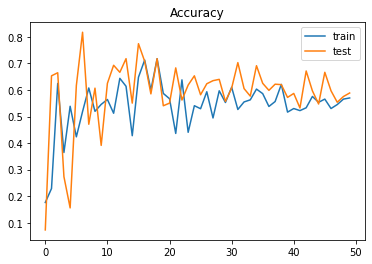

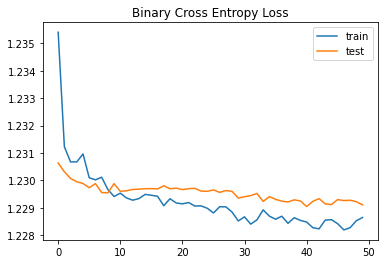

<Figure size 432x288 with 0 Axes>

In [179]:
#plot accuracy 
plt.subplot()
plt.title("Accuracy")
plt.plot(hist.history["accuracy"], label = 'train')
plt.plot(hist.history["val_accuracy"], label = 'test')
plt.legend()
plt.show()
plt.savefig('NN_preSMOTE_accucracy.png')

#plot loss
plt.subplot()
plt.title("Binary Cross Entropy Loss")
plt.plot(hist.history["loss"], label = 'train')
plt.plot(hist.history["val_loss"], label = 'test')
plt.legend()
plt.show()
plt.savefig('NN_preSMOTE_loss.png')

In [26]:
#wrapper 
neural_network = KerasClassifier(build_fn=create_network(**{'X_train' : X_train, 'y_train' : y_train}), epochs = 200, batch_size = 20, verbose = 0)

#grid search 
param_space = dict(epochs = [50, 100, 150, 200])
grid_results = GridSearchCV(neural_network, param_grid= param_space, cv = kf)

#evaluate neural network with 5-fold cross-validation 
cross_val_score(neural_network, X_train, y_train, cv =kf).mean()

made it to the function! heres x_train:
[[40  0  1 ...  0  1  1]
 [56  0  1 ...  0  0  3]
 [36  0  1 ...  0  0  1]
 ...
 [46  0  1 ...  0  0  1]
 [18  0  0 ...  0  0  0]
 [15  0  0 ...  0  0  1]]
and here's y_train:
[[1 1 1 1 1]
 [0 0 1 0 0]
 [1 0 1 0 0]
 ...
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 0 1]]


TypeError: cannot pickle '_thread.RLock' object

## Results after SMOTE

In [142]:
from imblearn.over_sampling import SMOTE
from collections import Counter
data = pd.read_csv('../Data_sets/Master_cleaned.csv')
data = remove_unwanted_observations(data)
X = data[data.columns[17:28]].values
y = data.Skin_Type
from sklearn.preprocessing import StandardScaler
sc= StandardScaler()
X_train = sc.fit_transform(X_train)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, random_state = 1024, stratify=y)

In [143]:
#SMOTE
num = 100
num2 = 50

# summarize the class distribution
counter = Counter(y_train)
print(f"Before resampling:\n{counter}\n") 

oversample = SMOTE(k_neighbors = 3, sampling_strategy = {"['Combination', 'Normal', 'Oily']": num, 
                                                         "['Combination', 'Oily']": num,
                                                         "['Dry']": num,
                                                         "['Normal']": num,
                                                         "['Combination', 'Dry', 'Normal', 'Sensitive']": num,
                                                         "['Dry', 'Normal']": num,
                                                         "['Combination', 'Dry', 'Normal']": num,
                                                         "['Combination']": num,
                                                         "['Sensitive']": num2,
                                                         "['Combination', 'Normal']": num2,
                                                         "['Dry', 'Normal', 'Sensitive']": num2,
                                                         "['Dry', 'Sensitive']": num2,
                                                         "['Combination', 'Dry']": num2,
                                                         "['Oily']": num2,
                                                         "['Combination', 'Normal', 'Oily', 'Sensitive']": num2,
                                                         "['Combination', 'Dry', 'Oily']": num2,
                                                         "['Normal', 'Sensitive']": num2,
                                                         "['Combination', 'Oily', 'Sensitive']": num2,
                                                         "['Combination', 'Dry', 'Sensitive']": num2
                                                        })
X_train, y_train = oversample.fit_resample(X_train, y_train)

# summarize the new class distribution
counter = Counter(y_train)
print(f"After resampling:\n{counter}\n") 

Before resampling:
Counter({"['Combination', 'Dry', 'Normal', 'Oily', 'Sensitive']": 643, "['Combination', 'Dry', 'Normal', 'Oily']": 167, "['Combination', 'Normal', 'Oily']": 79, "['Combination', 'Oily']": 64, "['Normal']": 58, "['Dry', 'Normal']": 50, "['Dry']": 50, "['Combination', 'Dry', 'Normal']": 46, "['Combination', 'Dry', 'Normal', 'Sensitive']": 43, "['Combination']": 41, "['Sensitive']": 32, "['Combination', 'Normal']": 21, "['Dry', 'Normal', 'Sensitive']": 20, "['Oily']": 18, "['Combination', 'Dry']": 16, "['Combination', 'Normal', 'Oily', 'Sensitive']": 16, "['Dry', 'Sensitive']": 13, "['Combination', 'Dry', 'Oily']": 9, "['Normal', 'Sensitive']": 9, "['Combination', 'Oily', 'Sensitive']": 7, "['Combination', 'Dry', 'Sensitive']": 5})

After resampling:
Counter({"['Combination', 'Dry', 'Normal', 'Oily', 'Sensitive']": 643, "['Combination', 'Dry', 'Normal', 'Oily']": 167, "['Normal']": 100, "['Combination', 'Dry', 'Normal', 'Sensitive']": 100, "['Combination']": 100, "['Com

In [144]:
y_train = y_train.apply(ast.literal_eval)
y_test = y_test.apply(ast.literal_eval)

mlb=MultiLabelBinarizer()
y_train = mlb.fit_transform(y_train)
y_test = mlb.transform(y_test)
mlb.classes_

array(['Combination', 'Dry', 'Normal', 'Oily', 'Sensitive'], dtype=object)

Epoch 1/200
108/108 [==============================] - 0s 3ms/step - loss: 0.6491 - accuracy: 0.0829 - val_loss: 0.5881 - val_accuracy: 0.0647
Epoch 2/200
108/108 [==============================] - 0s 2ms/step - loss: 0.6372 - accuracy: 0.2639 - val_loss: 0.5920 - val_accuracy: 0.3648
Epoch 3/200
108/108 [==============================] - 0s 2ms/step - loss: 0.6350 - accuracy: 0.4852 - val_loss: 0.5864 - val_accuracy: 0.6982
Epoch 4/200
108/108 [==============================] - 0s 2ms/step - loss: 0.6325 - accuracy: 0.6065 - val_loss: 0.5789 - val_accuracy: 0.7960
Epoch 5/200
108/108 [==============================] - 0s 2ms/step - loss: 0.6308 - accuracy: 0.5593 - val_loss: 0.5883 - val_accuracy: 0.7280
Epoch 6/200
108/108 [==============================] - 0s 3ms/step - loss: 0.6288 - accuracy: 0.6477 - val_loss: 0.5824 - val_accuracy: 0.6534
Epoch 7/200
108/108 [==============================] - 0s 2ms/step - loss: 0.6250 - accuracy: 0.5505 - val_loss: 0.5783 - val_accuracy: 0.6899

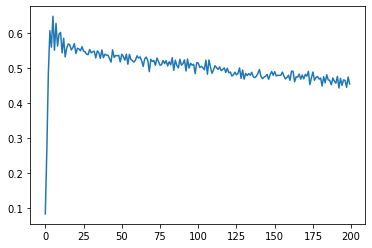

In [59]:
model = Sequential()
model.add(Dense(20, input_dim=X_train.shape[1], kernel_initializer ="random_uniform", activation = 'relu'))

model.add(Dense(y_train.shape[1], activation ='sigmoid'))
model.compile(loss="binary_crossentropy", optimizer = 'adam', metrics =['accuracy'])
hist = model.fit(X_train, y_train, validation_data = (X_test, y_test),epochs=200, batch_size = 20)
results = model.evaluate(X_test, y_test, verbose = 0)
plt.plot(hist.history["accuracy"])
plt.show()

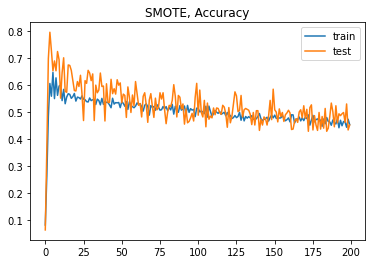

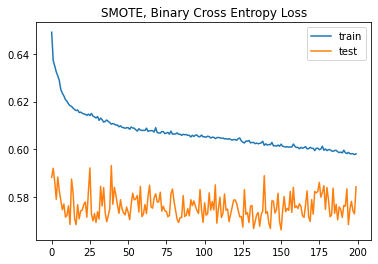

In [60]:
#plot accuracy 
plt.subplot()
plt.title("SMOTE, Accuracy")
plt.plot(hist.history["accuracy"], label = 'train')
plt.plot(hist.history["val_accuracy"], label = 'test')
plt.legend()
plt.show()

#plot loss
plt.subplot()
plt.title("SMOTE, Binary Cross Entropy Loss")
plt.plot(hist.history["loss"], label = 'train')
plt.plot(hist.history["val_loss"], label = 'test')
plt.legend()
plt.show()

## Fine-tuning the network with Randomized Grid Search

In [163]:
# defining the baseline model:
def build_network(initializer, act, units,dropout_rate = 0.2):
    classifier = Sequential()
    #First Hidden Layer
    classifier.add(Dense(units=units, activation=act , kernel_initializer= initializer, input_dim=11))
    classifier.add(Dropout(dropout_rate))
    #Second  Hidden Layer
    classifier.add(Dense(units=units, activation=act , kernel_initializer= initializer))
    classifier.add(Dropout(dropout_rate))
    #Output Layer
    classifier.add(Dense(5, activation = act, kernel_initializer= initializer))
    #Compiling the neural network
    classifier.compile(optimizer='adam',loss='binary_crossentropy', metrics =['accuracy'])
    return classifier

In [165]:
from sklearn.metrics import make_scorer, log_loss
from sklearn.model_selection import RandomizedSearchCV
# defining baseline model 
classifier = KerasClassifier(build_fn=build_network, verbose=0)

# define the grid search parameters
param_grid = {
              'epochs':[10,50,100,150,200],
              'batch_size' :          [20, 32, 64, 128],
              'dropout_rate' :        [0.1, 0.2, 0.3, 0.4],
              'act' :          ['relu', 'elu', 'softmax'],
              #'optimizer' :           ['Adam', 'Nadam','rmsprop','SGD'],
              'units': range(4,9), 
              'initializer':          ["random_normal",'sigmoid', "random_uniform", "truncated_normal", 'normal', 
             'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
             }

# create custome binary cross entropy loss scorer 
bce_scorer = make_scorer(log_loss, greater_is_better= False)


# Run grid search 
gridSearch = RandomizedSearchCV(estimator=classifier,
                            param_distributions = param_grid,
                            cv=5, n_jobs=-1,
                            return_train_score=True
                            )

gridSearch.fit(X_train, y_train)

# print best parameters
print('Grid Search Best score',gridSearch.best_score_)
print('Grid Search Best Parameters', gridSearch.best_params_)
print('Execution time',gridSearch.refit_time_)


# summarize results
print("Best: %f using %s" % (gridSearch.best_score_, 
                             gridSearch.best_params_))
means = gridSearch.cv_results_['mean_test_score']
stds = gridSearch.cv_results_['std_test_score']
params = gridSearch.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Grid Search Best score 0.6699074089527131
Grid Search Best Parameters {'units': 4, 'initializer': 'random_normal', 'epochs': 200, 'dropout_rate': 0.4, 'batch_size': 128, 'act': 'elu'}
Execution time 7.0607359409332275
Best: 0.669907 using {'units': 4, 'initializer': 'random_normal', 'epochs': 200, 'dropout_rate': 0.4, 'batch_size': 128, 'act': 'elu'}
0.477778 (0.243980) with: {'units': 4, 'initializer': 'he_normal', 'epochs': 100, 'dropout_rate': 0.1, 'batch_size': 64, 'act': 'softmax'}
0.556019 (0.341139) with: {'units': 7, 'initializer': 'glorot_normal', 'epochs': 10, 'dropout_rate': 0.1, 'batch_size': 128, 'act': 'softmax'}
0.422222 (0.369242) with: {'units': 7, 'initializer': 'truncated_normal', 'epochs': 200, 'dropout_rate': 0.4, 'batch_size': 128, 'act': 'elu'}
0.256019 (0.309731) with: {'units': 4, 'initializer': 'he_uniform', 'epochs': 50, 'dropout_rate': 0.2, 'batch_size': 20, 'act': 'elu'}
0.556019 (0.341139) with: {'units': 4, 'initializer': 'normal', 'epochs': 10, 'dropout_

In [166]:
model = Sequential()
#First Hidden Layer
model.add(Dense(units=4, activation='elu', kernel_initializer= 'random_normal', input_dim=11))
model.add(Dropout(.4))
#Second  Hidden Layer
model.add(Dense(units=4, activation='elu', kernel_initializer='random_normal'))
model.add(Dropout(.4))
#Output Layer
model.add(Dense(5, activation='softmax', kernel_initializer='random_normal'))
#Compiling the neural network
model.compile(optimizer='adam', loss='binary_crossentropy', metrics =['accuracy'])
# results
hist = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=200, batch_size = 128)
results = model.evaluate(X_test, y_test, verbose = 0)





Epoch 1/200
17/17 [==============================] - 0s 15ms/step - loss: 1.1057 - accuracy: 0.2833 - val_loss: 1.2377 - val_accuracy: 0.0464
Epoch 2/200
17/17 [==============================] - 0s 8ms/step - loss: 1.1036 - accuracy: 0.3171 - val_loss: 1.2357 - val_accuracy: 0.0531
Epoch 3/200
17/17 [==============================] - 0s 4ms/step - loss: 1.1016 - accuracy: 0.3662 - val_loss: 1.2335 - val_accuracy: 0.7811
Epoch 4/200
17/17 [==============================] - 0s 4ms/step - loss: 1.0997 - accuracy: 0.4889 - val_loss: 1.2321 - val_accuracy: 0.8209
Epoch 5/200
17/17 [==============================] - 0s 3ms/step - loss: 1.0988 - accuracy: 0.5773 - val_loss: 1.2316 - val_accuracy: 0.8209
Epoch 6/200
17/17 [==============================] - 0s 3ms/step - loss: 1.0984 - accuracy: 0.6102 - val_loss: 1.2314 - val_accuracy: 0.8209
Epoch 7/200
17/17 [==============================] - 0s 3ms/step - loss: 1.0981 - accuracy: 0.6968 - val_loss: 1.2314 - val_accuracy: 0.8209
Epoch 8/200


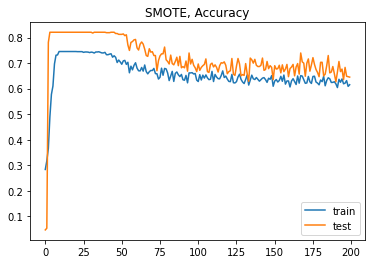

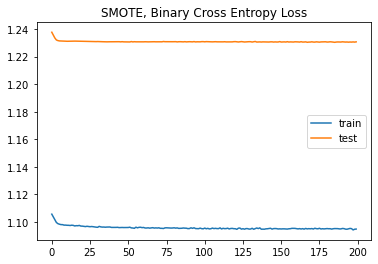

In [167]:
#plot accuracy 
plt.subplot()
plt.title("SMOTE, Accuracy")
plt.plot(hist.history["accuracy"], label = 'train')
plt.plot(hist.history["val_accuracy"], label = 'test')
plt.legend()
plt.show()

#plot loss
plt.subplot()
plt.title("SMOTE, Binary Cross Entropy Loss")
plt.plot(hist.history["loss"], label = 'train')
plt.plot(hist.history["val_loss"], label = 'test')
plt.legend()
plt.show()